Notebook purpose

- Understand role of spend distribution for savings behaviour

In [11]:
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import s3fs
import seaborn as sns
import statsmodels.formula.api as smf
from scipy import stats

sys.path.append("/Users/fgu/dev/projects/entropy")
import entropy.data.aggregators as ag
import entropy.data.cleaners as cl
import entropy.data.make_data as md
import entropy.data.selectors as sl
import entropy.data.validators as vl
import entropy.helpers.aws as ha
import entropy.helpers.data as hd
import entropy.helpers.helpers as hh

pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)
pd.set_option("max_colwidth", None)
%load_ext autoreload
%autoreload 2

fs = s3fs.S3FileSystem(profile="3di")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data

In [2]:
dft = hd.read_txn_data("X77")
dfa = hd.read_analysis_data("X77")

Time for read_txn_data                 : 34.85 seconds
Time for read_analysis_data            : 0.50 seconds


Defind index of user-months for series subsetting

In [3]:
dfa_users = dfa.set_index(["user_id", "ym"]).index

Add counts so we can easily inspect

In [13]:
def counts(df, cat):
    """User-month txn counts by spend catetory."""
    group_cols = [df.user_id, df.ym, cat]
    return (
        df.loc[df.tag_group.eq("spend") & df.is_debit]
        .groupby(group_cols, observed=True)
        .size()
        .unstack()
        .fillna(0)
        .rename(columns=lambda x: "count_" + x)
    )


s = counts(dft, "tag").reset_index()
dfa = dfa.merge(s, how="left", validate="1:1")

In [14]:
import functools

regplot = functools.partial(
    sns.regplot,
    data=dfa,
    scatter_kws=dict(alpha=0.1, edgecolor="white"),
    line_kws=dict(color="orange", linestyle="dashed"),
    lowess=True,
)


def regplot_entropy_on_x(x, **kwargs):
    fig, ax = plt.subplots(2, 3, figsize=(15, 10))
    for i, m in enumerate(["tag", "tag_auto", "merchant"]):
        regplot(x=x, y=f"entropy_{m}", ax=ax[0, i], **kwargs)
        regplot(x=x, y=f"entropy_{m}_s", ax=ax[1, i], **kwargs)

## Question of interest

We are interested in how users spending profiles are related to their saving behaviour. The below shows random spending profiles of a random user in our data.

In [17]:
def random_user_data(df, cols="count"):
    """Return counts for random user.

    Args:
    df: Analysis dataframe with spend category spend values and counts.
    cols: Group of columns from {count, spend}.
    """
    user = np.random.choice(df.user_id.unique())
    return df[df.user_id.eq(user)].filter(regex=f"^{cols}")


random_user_data(dfa).head(10)

,count_communication,count_services,count_household,count_finance,count_other_spend,count_retail,count_motor,count_travel,count_hobbies
3528,6.0,9.0,10.0,15.0,10.0,0.0,1.0,2.0,0.0
3529,6.0,17.0,15.0,12.0,12.0,0.0,1.0,0.0,0.0
3530,4.0,11.0,12.0,10.0,6.0,2.0,0.0,0.0,0.0
3531,3.0,8.0,9.0,7.0,4.0,1.0,2.0,2.0,0.0
3532,3.0,5.0,23.0,9.0,4.0,2.0,0.0,1.0,0.0
3533,3.0,6.0,14.0,4.0,6.0,3.0,3.0,1.0,0.0
3534,3.0,7.0,19.0,7.0,2.0,2.0,1.0,1.0,1.0
3535,3.0,11.0,11.0,8.0,3.0,2.0,0.0,2.0,2.0
3536,3.0,6.0,17.0,6.0,5.0,4.0,6.0,12.0,0.0
3537,4.0,5.0,13.0,6.0,1.0,4.0,9.0,3.0,0.0


## Data level characteristics

### What do people spend money on?

In [33]:
counts = dfa.filter(regex="^count_")
spends = dfa.filter(regex="^spend_")

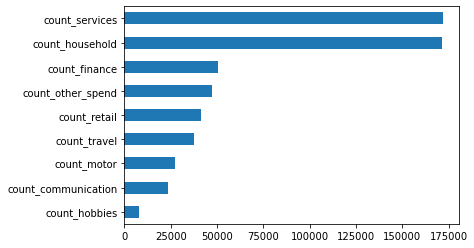

In [60]:
counts.sum().sort_values().plot(kind="barh");

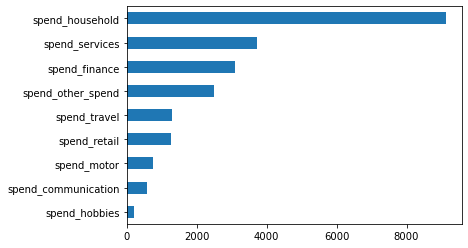

In [61]:
spends.sum().sort_values().plot(kind="barh");

In [68]:
counts.melt()

,variable,value
0,count_communication,3.0
1,count_communication,4.0
2,count_communication,5.0
3,count_communication,5.0
4,count_communication,4.0
...,...,...
78403,count_hobbies,0.0
78404,count_hobbies,0.0
78405,count_hobbies,0.0
78406,count_hobbies,0.0


<AxesSubplot:xlabel='variable', ylabel='value'>

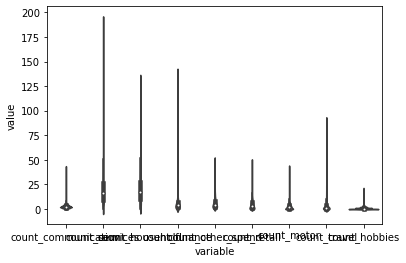

In [69]:
sns.violinplot(y="value", x="variable", data=counts.melt())

In [63]:
sns.violinplot(counts)

/Users/fgu/miniconda3/envs/entropy/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

## Characterising spending profiles

All on user-month level.

Global
- Number of transactions
- Total spend
- Average spend

Distribution of spends
- 

Case study generator

In [ ]:
random_user_data(dfa, cols="spend").head(10)

## Relationship between smoothed and unsmoothd entropy

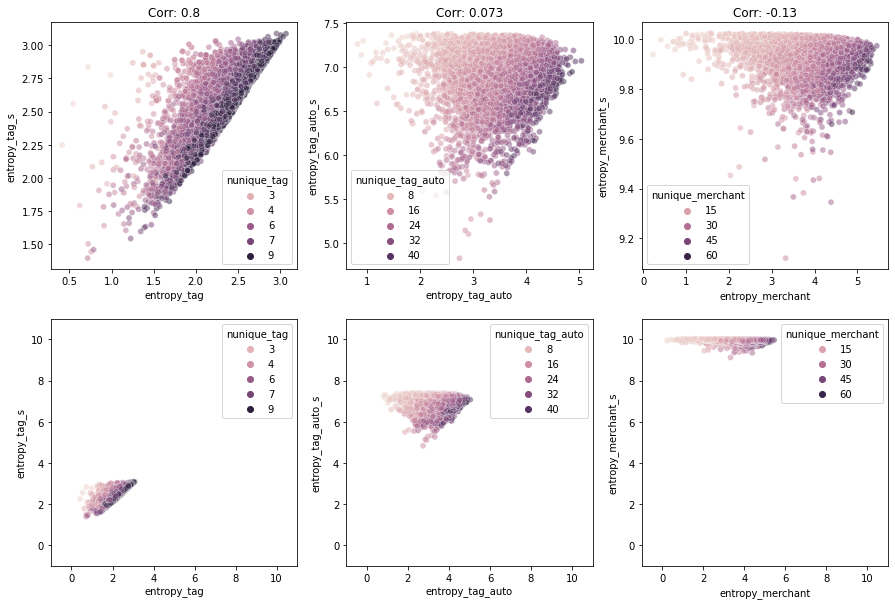

In [9]:
import functools

fig, ax = plt.subplots(2, 3, figsize=(15, 10))
for i, m in enumerate(["tag", "tag_auto", "merchant"]):
    y = f"entropy_{m}_s"
    x = f"entropy_{m}"
    hue = f"nunique_{m}"
    data = dfa
    alpha = 0.5

    scatter = functools.partial(
        sns.scatterplot, x=x, y=y, hue=hue, data=data, alpha=alpha
    )
    scatter(ax=ax[0, i]).set(title=f"Corr: {data[x].corr(data[y]):.2}")
    scatter(ax=ax[1, i]).set(xlim=(-1, 11), ylim=(-1, 11))

For more on relationshiop between the two, see `entropy_calculation.ipynb`. Basically, smoothing turns (user-month spend) distributions with many zero counts from low entropy to high entropy scores. Hence, the more distributions with a large number of zero scores there are, the higher the impact of smoothing, and the lower the relationship between smoothed and unsmoothed scores. The three different categorical variables shown are increasing in their number of unique categories, and hence in the number of possible (and actual) zeroes. As a result, the correlation weakens as we move from left to right.

## Understanding unsmoothed entropy

**Unsmoothed entropy** increases with the number of unique categories a user spends money on, and is positively related to sa inflows. Hence: users who spend across more categories are more likely to save.

**Smoothed entropy** increases in the similarity of the category counts and as the number of txns decreases, and is negatively related to sa inflows. Hence: users with more equal counts and a larger number of txns are less likely to save.


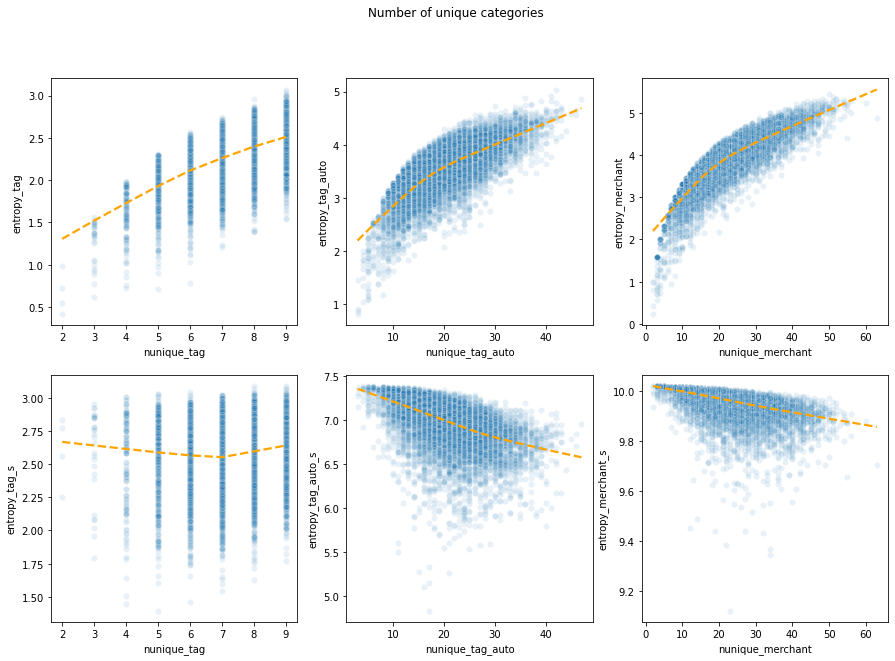

In [14]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
plt.suptitle("Number of unique categories")
for i, m in enumerate(["tag", "tag_auto", "merchant"]):
    x = f"nunique_{m}"
    regplot(x=x, y=f"entropy_{m}", ax=ax[0, i])
    regplot(x=x, y=f"entropy_{m}_s", ax=ax[1, i])

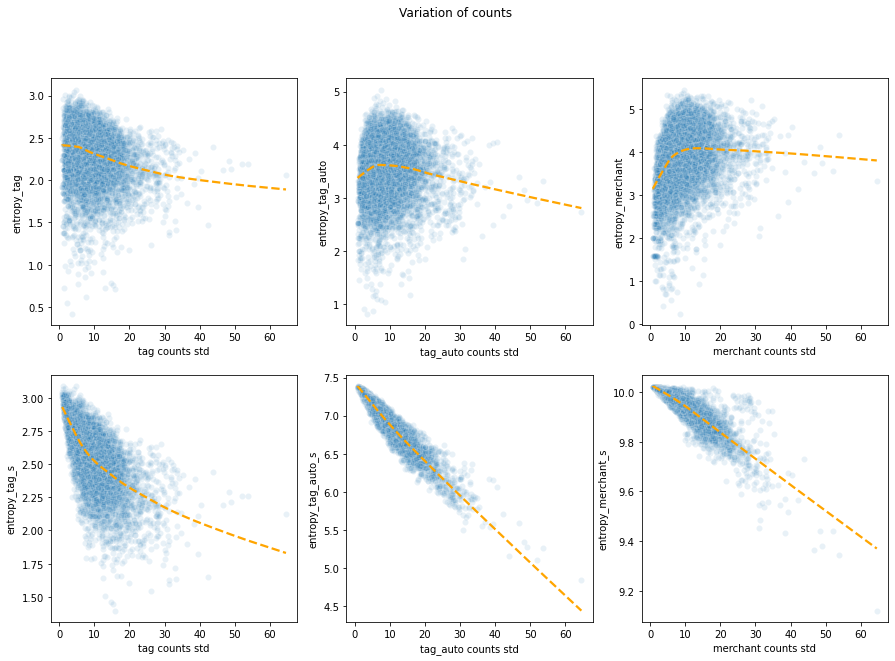

In [18]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
plt.suptitle("Variation of counts")
for i, m in enumerate(["tag", "tag_auto", "merchant"]):
    x = ag._entropy_counts(dft, "tag").std(1).loc[dfa_users].rename(f"{m} counts std")
    regplot(x=x, y=f"entropy_{m}", ax=ax[0, i])
    regplot(x=x, y=f"entropy_{m}_s", ax=ax[1, i])

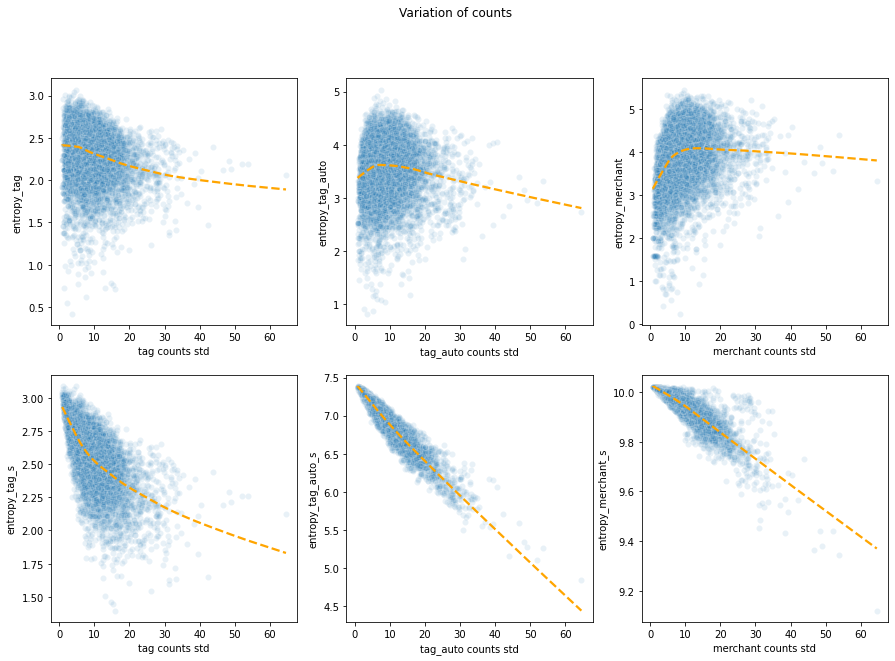

In [25]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
plt.suptitle("Variation of counts")
for i, m in enumerate(["tag", "tag_auto", "merchant"]):
    x = (
        ag._entropy_base_values(dft, "tag")
        .std(1, skipna=True)
        .loc[dfa_users]
        .rename(f"{m} counts std")
    )
    regplot(x=x, y=f"entropy_{m}", ax=ax[0, i])
    regplot(x=x, y=f"entropy_{m}_s", ax=ax[1, i])

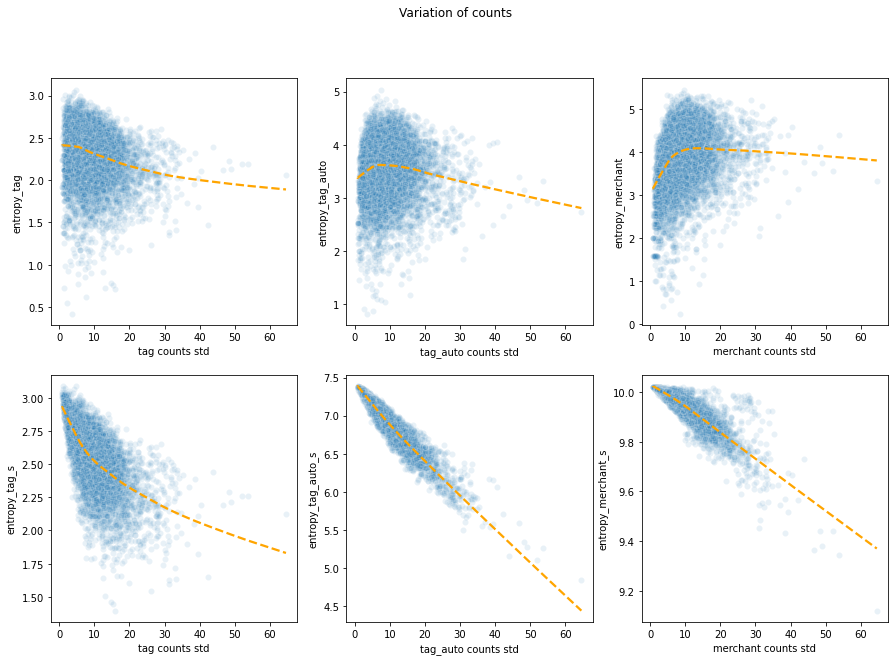

In [24]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
plt.suptitle("Variation of counts")
for i, m in enumerate(["tag", "tag_auto", "merchant"]):
    x = (
        ag._entropy_base_values(dft, "tag")
        .std(1, skipna=False)
        .loc[dfa_users]
        .rename(f"{m} counts std")
    )
    regplot(x=x, y=f"entropy_{m}", ax=ax[0, i])
    regplot(x=x, y=f"entropy_{m}_s", ax=ax[1, i])

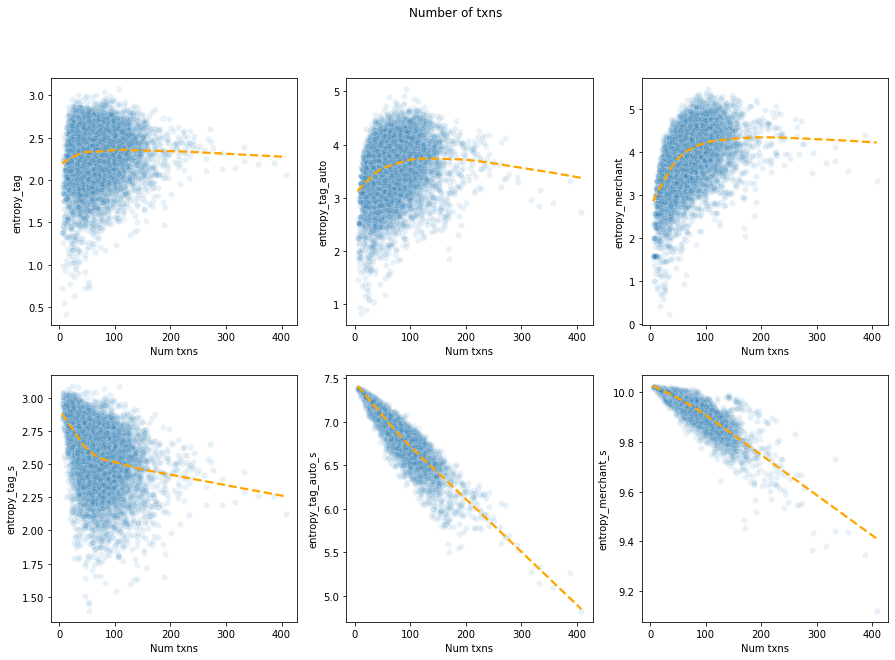

In [17]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
plt.suptitle("Number of txns")
for i, m in enumerate(["tag", "tag_auto", "merchant"]):
    x = ag._entropy_counts(dft, "tag").sum(1).loc[dfa_users].rename(f"Num txns")
    regplot(x=x, y=f"entropy_{m}", ax=ax[0, i])
    regplot(x=x, y=f"entropy_{m}_s", ax=ax[1, i])